In [1]:
import numpy as np
from numba import jit,njit
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
from scipy import sparse
import skimage
import tifffile as tiff
import os
import math
import operator
from com import *
from skeleton import *
from tqdm.notebook import tqdm


In [2]:
imgspath = "/home/isis0517/Documents/data/200324_male_siedview_3"
#imgspath = "/home/isis0517/Documents/data/imgs"

def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)//2


40000


(500, 2040)


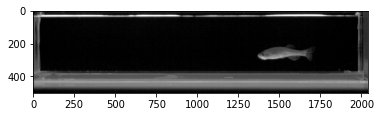

In [3]:
test_frame = np.load(os.path.join(imgspath, flist[5150]))
plt.imshow(test_frame, plt.cm.gray)
print(test_frame.shape)

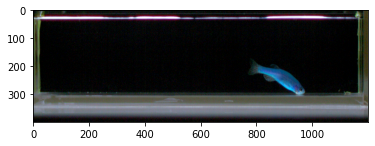

In [4]:
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (1200,800))
for s in tqdm(range(data_len)):
    
    b = cv2.resize(np.flip(np.load(os.path.join(imgspath, flist[s+data_len]))), (1200,400))
    b = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    a = cv2.resize(a, (1200,400))
    video.write(np.concatenate((b, a), axis=0))
video.release()
plt.imshow(a)


In [5]:

cv2.imwrite("test.png", a)

True

In [6]:
tnum = np.random.randint(data_len,size = int(data_len*0.2))
a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
back = np.zeros(a.shape)
for s in tnum:
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    back += a
back = back/len(tnum)
back = back.astype('uint8')

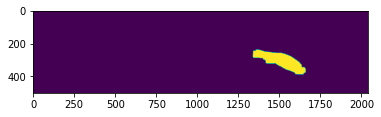

In [7]:
video = cv2.VideoWriter("output1.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (a.shape[1], a.shape[0]), True)
kernel = np.ones((3,3), np.uint8)
for s in tqdm(range(data_len)):
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, back)>30)*255).astype('uint8')
    
    diff = cv2.erode(diff, kernel, iterations = 4)
    diff = cv2.dilate(diff, kernel, iterations = 6)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    video.write(cv2.bitwise_and(a, a, mask = diff)) #apply mask
    
video.release()

    
diff = cv2.dilate(diff, kernel, iterations = 3)
plt.imshow(diff)
#cv2.imwrite("test.png", diff)

In [8]:
labels = label(diff, connectivity=2, background=0)
group = regionprops(labels, cache=True)

# 找出ZebraPCA

## 產生背景

In [9]:
tnum = np.random.randint(data_len,size = 1000)
a = np.load(os.path.join(imgspath, flist[10+data_len]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s+data_len]))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


## 轉正圖片 & 儲存

In [10]:
NT_skeleton(background, di_num=3)


array([[ 465, 1296],
       [ 431, 1190],
       [ 431, 1069],
       [ 431,  948],
       [ 431,  829],
       [ 431,  708],
       [ 431,  587],
       [ 432,  466],
       [ 432,  345],
       [ 464,  240]])

In [11]:
imgs = []
h_ans = []

for s in tqdm(range(data_len)):
    
    img = np.load(os.path.join(imgspath, flist[s+data_len]))
    img = cv2.absdiff(img, background)
    img = np.where(img>120, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    imgs.append(rotated)
    h_ans.append(angle)

-0.12832322768579477


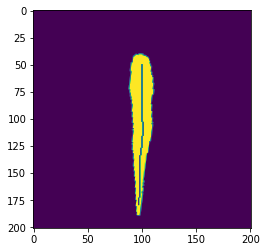

In [86]:
s = 15240
sk = NT_skeleton(imgs[s])

print(h_ans[15240])
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(draw)
#plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
#plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))

### save as video

In [13]:
video = cv2.VideoWriter("output_v.avi", cv2.VideoWriter_fourcc(*"MJPG"), 10, (imgs[0].shape[1], imgs[0].shape[0]), False)

for s, img in enumerate(tqdm(imgs)):
    try :
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
    draw = img.copy()
    for n in range(len(sk)-1):
        cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
    video.write(draw)
video.release()

## apply the eigenfish

In [14]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)



han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    han_sks.append(han_sk)
print(len(han_sks))    



20000


## find the pca

[0.89944562 0.05799886 0.01220802 0.01196525 0.00588689] 0.9875046427745604


array([-0.26455731, -0.08825795, -0.0330074 ,  0.12657473, -0.09731156])

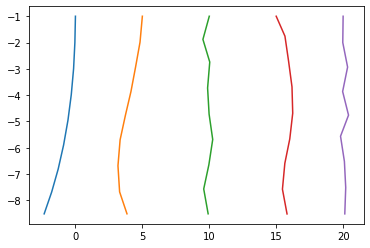

In [15]:

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

## apply the Kmeans

In [16]:
from sklearn.cluster import KMeans

n_clusters = 22
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-10, n_init=20)
kmeans.fit(pca_sks)
labels = kmeans.predict(pca_sks)
centers = kmeans.cluster_centers_

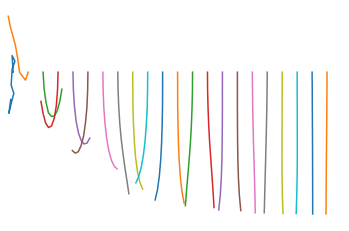

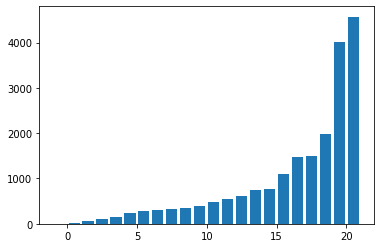

In [17]:
nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
#plt.axis('off')
plt.show()

0


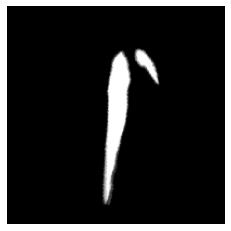

1


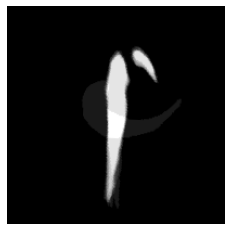

2


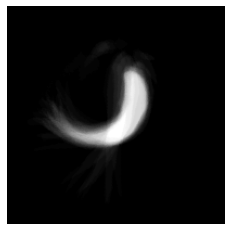

3


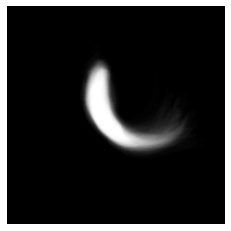

4


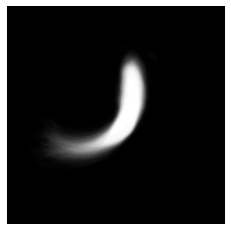

5


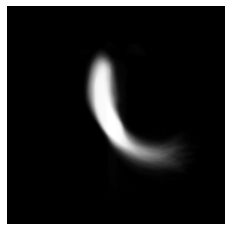

6


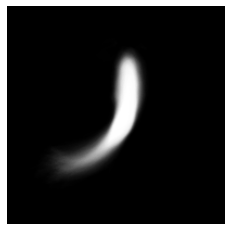

7


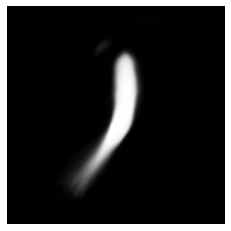

8


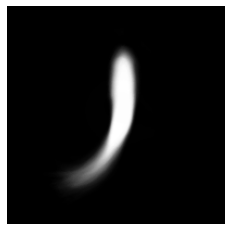

9


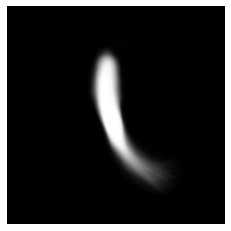

10


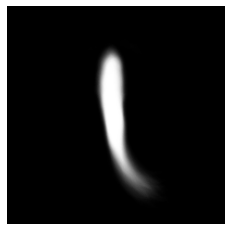

11


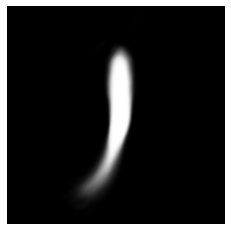

12


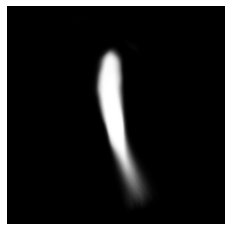

13


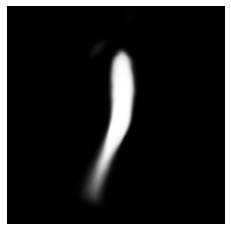

14


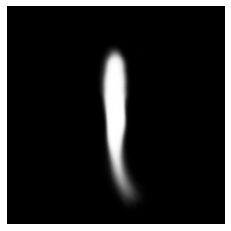

15


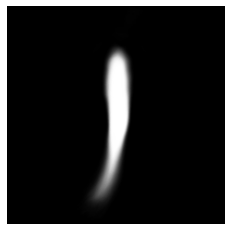

16


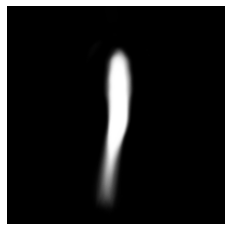

17


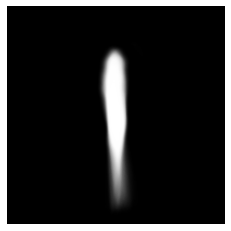

18


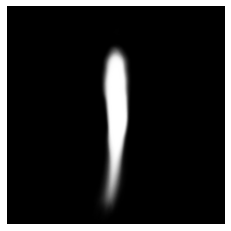

19


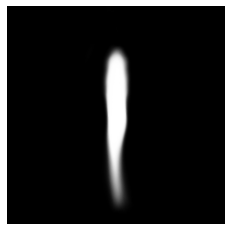

20


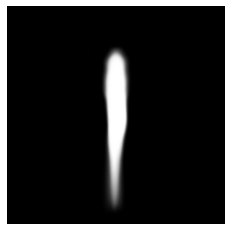

21


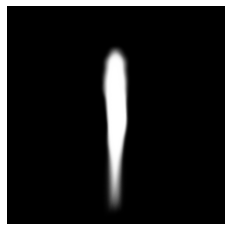

In [18]:
cen_imgs = np.zeros((n_clusters, 201, 201), dtype='int')
for s, label in enumerate(labels[:len(imgs)]):
    cen_imgs[label] += imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()

In [19]:
_, bins = np.histogram(np.abs(h_ans))
dic_ans = np.digitize(np.abs(h_ans), bins)

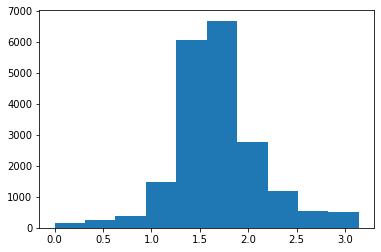

In [20]:
_ = plt.hist(np.abs(h_ans))

# 產生對應的side view

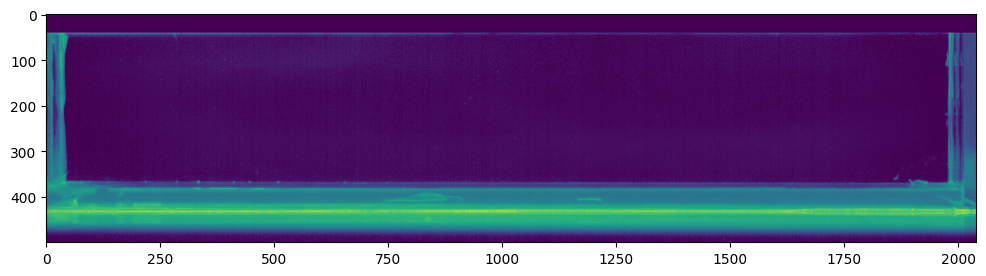

In [21]:
tnum = np.random.randint(data_len,size = int(data_len*0.2))
a = np.load(os.path.join(imgspath, flist[10]))
side_back = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s]))
    side_back += a
side_back = side_back/len(tnum)
side_back = side_back.astype('uint8')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(side_back)

aq_mask = np.full(a.shape, True)
aq_mask[0:41, ...] = False
plt.imshow(side_back*aq_mask)
aq_mask = np.where(aq_mask, 255, 0).astype('uint8')


In [22]:

stand = np.zeros((401, 401, 3), dtype=np.uint8)
cv2.rectangle(stand, (50, 160), (350, 240), (1,1,1), -1)
print(np.sum(stand*150))

sideviews = []
kernel = np.ones((3,3), np.uint8)
for s in tqdm(range(data_len)):
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2GRAY)
    diff = ((cv2.absdiff(a, side_back)>30)*255).astype('uint8')
    cv2.bitwise_and(diff, diff, mask = aq_mask) #apply mask
    
    diff = cv2.erode(diff, kernel, iterations = 3)
    diff = cv2.dilate(diff, kernel, iterations = 5)
    a = cv2.cvtColor(np.load(os.path.join(imgspath, flist[s])), cv2.COLOR_BAYER_BG2RGB)
    side = cv2.bitwise_and(a, a, mask = diff)#apply mask
    img = cutting_img(side, get_pos(diff), size = 200)
    if h_ans[s] < 0:
        img = img[:, ::-1, ...]
    #print(np.sum(img*stand))
    sideviews.append(img)
    

#cv2.imwrite("test.png", diff)

10971450


In [23]:
ords = np.lexsort(pca_sks.T[::-1], axis=-1)
sort_pca = pca_sks[ords]
inv_ords = np.zeros(len(pca_sks))
inv_ords[ords] = np.arange(len(pca_sks), dtype=np.int)

pca_sks[0:10].T[::-1]
print(pca_sks[ords])

[[-5.70684287e+00 -2.15954895e+00  3.04261482e+00 -1.46085068e+00
   6.56683356e-01]
 [-5.68395915e+00 -1.93874946e+00  2.32820148e-01  1.02174845e+00
   2.45706628e-01]
 [-5.39245967e+00 -8.81910671e-01  3.77370864e-02 -7.36284955e-02
  -8.76688227e-04]
 ...
 [ 5.37887826e+00  1.16565855e+00 -1.05800890e-01 -2.80313835e-01
  -1.12302207e-01]
 [ 5.69941836e+00  2.46045678e+00 -3.77089730e-01 -1.15983226e+00
  -1.86112080e-01]
 [ 5.79925417e+00  7.22004124e-01 -1.28929150e-01  3.88380365e-01
   2.90766448e-02]]


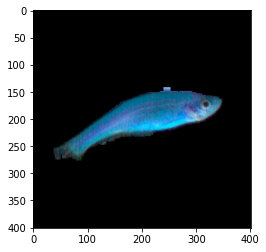

In [24]:
h_ans[200]
plt.imshow(sideviews[20])

In [119]:
class SortSearch:
    def __init__(self, arr):
        self.ords = np.lexsort(arr.T[::-1], axis=-1)
        self.sort_arr = arr[self.ords]
        self.length = len(arr)
        self.inv_ords = np.zeros(self.length, dtype=np.int)
        self.inv_ords[self.ords[:]] = np.arange(self.length, dtype=np.int)
    def find_floor(self, item) -> (int, np.ndarray):
        pass
    def search(self, item, lower=0, upper=None) -> int:
        if upper is None:
            upper = self.length
        item = np.array(item)
        while upper-lower>1:
#             print(f"lower : {lower}, upper : {upper}")
            mid = (lower+upper+1)//2
            com = np.array(self.sort_arr[mid])
            big = item > com
            sma = item < com
            if np.sum(np.logical_xor(big, sma)) == 0:
                upper = mid
                lower = mid
            
            for s in range(len(item)):
                if big[s]:
                    lower = mid
                    break
                elif sma[s]:
                    upper = mid
                    break
            print(upper, lower)
        return self.inv_ords[lower]
                    
            

## set angle range 

In [113]:
an_mask = np.where(np.logical_and(np.abs(h_ans)>1.2, np.abs(h_ans)<2), 1, 0)
print(an_mask[15240])
merge_arr = np.concatenate((np.expand_dims(an_mask, axis=1), pca_sks), axis=1)
print(sorter.length)
sorter = SortSearch(merge_arr)

0
20000


In [114]:
print(sorter.sort_arr[:10])

[[ 0.00000000e+00 -5.68395915e+00 -1.93874946e+00  2.32820148e-01
   1.02174845e+00  2.45706628e-01]
 [ 0.00000000e+00 -5.39245967e+00 -8.81910671e-01  3.77370864e-02
  -7.36284955e-02 -8.76688227e-04]
 [ 0.00000000e+00 -5.35529568e+00 -3.71189268e-01 -5.18764107e-02
  -4.14871979e-02 -1.21031061e-01]
 [ 0.00000000e+00 -5.11051458e+00 -1.55557098e-01 -6.65946906e-02
   1.24723531e-01  8.54573140e-02]
 [ 0.00000000e+00 -5.09028131e+00 -1.37383265e-01 -9.18980474e-03
  -1.48885775e-01 -1.67527329e-01]
 [ 0.00000000e+00 -4.84742913e+00 -5.14416724e-01 -2.02177965e-02
   9.00686662e-02  1.08545847e-01]
 [ 0.00000000e+00 -4.80369798e+00 -6.80606855e-01 -1.62377447e-01
  -4.92853754e-02  2.46068470e-02]
 [ 0.00000000e+00 -4.74093742e+00 -3.16154107e-01 -2.33031472e-01
  -2.45382132e-01  1.66257912e-02]
 [ 0.00000000e+00 -4.71667351e+00 -1.61265578e-01 -2.91953848e-02
   3.10040139e-02  1.63634467e-02]
 [ 0.00000000e+00 -4.67793991e+00 -5.12222226e-01  3.22645583e-02
  -1.05024545e-01 -6.3320

In [120]:
print(sorter.search([ 1.         ,-0.44405543,  0.57650871,  0.10474466, -0.06221365,  0.02841968]))
sorter.sort_arr[6750]

10000 0
10000 5000
7500 5000
7500 6250
6875 6250
6875 6563
6875 6719
6797 6719
6758 6719
6758 6739
6758 6749
6754 6749
6752 6749
6751 6749
6751 6750
18483


array([ 1.        , -0.44419877, -0.04443116, -0.02876919, -0.00916233,
       -0.00799379])

# load the other vidoe

this data is hard to get the posture 

['frame_0.npy', 'frame_1.npy', 'frame_2.npy', 'frame_3.npy', 'frame_4.npy', 'frame_5.npy', 'frame_6.npy', 'frame_7.npy', 'frame_8.npy', 'frame_9.npy', 'frame_10.npy', 'frame_11.npy', 'frame_12.npy', 'frame_13.npy', 'frame_14.npy', 'frame_15.npy', 'frame_16.npy', 'frame_17.npy', 'frame_18.npy', 'frame_19.npy']


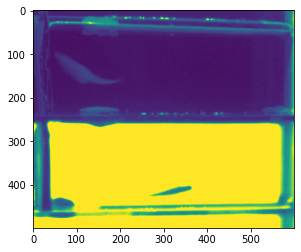

In [29]:
path2 = r"/home/isis0517/Documents/data/MFd/npy"
flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(temlist[:20])
flist2 = temlist
a = np.load(os.path.join(path2,flist2[0]))
plt.imshow(a)

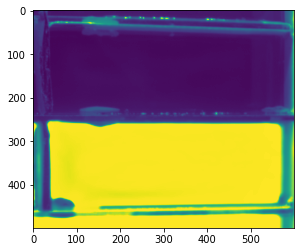

In [30]:

new_background = np.zeros(a.shape)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.3))
for s in tnum:
    a = np.load(os.path.join(path2, flist2[s]))
    new_background += a
    
new_background = new_background/len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

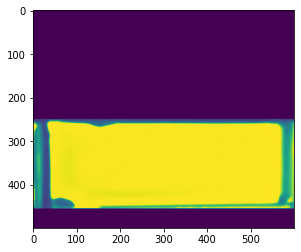

In [31]:
new_mask = np.full(new_background.shape, False)
new_mask[250:455, :] = True
plt.imshow(new_background*new_mask)

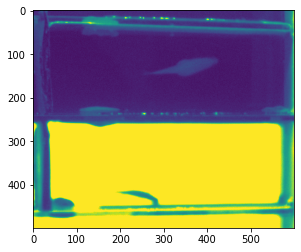

In [32]:
new_imgs = []
for filename in tqdm(flist2[:100]):
    img = np.load(os.path.join(path2, filename))
    img = (img/255)**0.9*255
    #img = img.astype(np.uint8)
    
    #img = cv2.absdiff(new_background, img)
    #img = np.where(img>100, 255, 0).astype('uint8')
    #pos = get_pos(img)
    #img = cutting_img(img, pos, 100)
plt.imshow(img)

# another vidoe

23430


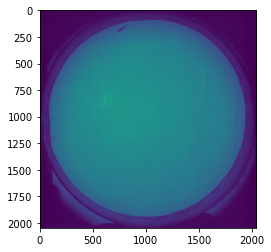

In [33]:
path2 = r"/media/isis0517/QVO2/0115/03"

flist2 = os.listdir(path2)
temlist = []
for filename in flist2:
    if filename.split(".")[-1] == "npy":
        temlist.append(filename)

temlist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(temlist))
flist2 = temlist[:-100]
img = np.load(os.path.join(path2,flist2[0]))
#img = (img/255)**0.6*255
plt.imshow(img)

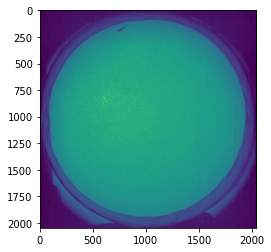

In [34]:
gamma = 0.7
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
res = cv2.LUT(img, lookUpTable)
plt.imshow(res)

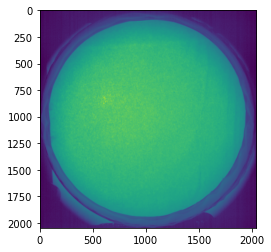

In [35]:
new_background = np.zeros(img.shape, dtype=np.float)
tnum = np.random.randint(len(flist2), size=int(len(flist2)*0.2))
for s in tqdm(tnum):
    img = np.load(os.path.join(path2, flist2[s]))
    img = cv2.LUT(img, lookUpTable)
    img = cv2.blur(img, (5, 5))
    new_background += img
    
new_background = new_background / len(tnum)
new_background = new_background.astype(np.uint8)
plt.imshow(new_background)

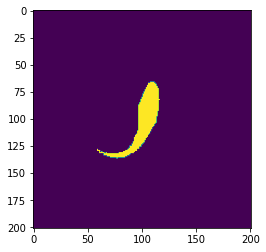

In [36]:
new_imgs = []
for filename in tqdm(flist2):
    img = np.load(os.path.join(path2, filename))
    img = cv2.LUT(img, lookUpTable)
    img = img.astype(np.uint8)
    img = cv2.blur(img, (5, 5))
    img = cv2.absdiff(new_background, img)
    img = np.where(img>30, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, 100)
    new_imgs.append(img)
plt.imshow(img)

In [37]:
now_roteds = []
new_h_ans = []

for img in tqdm(new_imgs):
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
        
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    
    now_roteds.append(rotated)
    new_h_ans.append(angle)

In [38]:

new_han_sks=[]

for s, img in enumerate(tqdm(now_roteds)):
    
    sk = NT_skeleton(img, di_num=5)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    new_han_sks.append(han_sk)
print(len(new_han_sks))    



23330


In [75]:
new_pca_sks = pca.transform(new_han_sks)
new_merge_sks = np.concatenate((np.ones((len(new_pca_sks),1)), new_pca_sks), axis=1)
sorter.search(new_merge_sks[0])

17629

In [102]:
video = cv2.VideoWriter("output_v.avi", 0, 3, (sideviews[0].shape[1], sideviews[0].shape[0]))
for sks in tqdm(new_merge_sks[:3000]):
    ind = sorter.search(sks)
    if ind == 18483:
        print(sks, merge_arr[18483])
        break
    img = sideviews[ind].copy()
    img = cv2.putText(img, f"{ind}", (20,20), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (200,200,200), 1)
    video.write(img)
video.release()

[ 1.         -0.44405543  0.57650871  0.10474466 -0.06221365  0.02841968] [ 0.         -2.1332922   0.15315134 -0.01399988  0.09750243 -0.0238278 ]

